# Document Classification - HR

This R&D project aims to develop a machine learning solution for automating HR document classification, targeting the efficient categorization of over 2400 resumes from livecareer.com. With resumes organized in PDF format across various job categories, the system minimizes manual HR efforts by validating and automating applicant categorization. 

The goal is to automate resume categorization with high accuracy and minimal human intervention, enhancing the efficiency and effectiveness of the hiring process by ensuring accurate and consistent applicant categorization, identifying mismatches, and streamlining recruitment, ultimately saving time and improving the overall hiring strategy.

In [ ]:
# install necessary packages
!pip install -q -r requirements.txt

In [ ]:
# Import necessary libraries and modules
import boto3
import sagemaker
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile
import csv
import os
from tqdm import tqdm  # Import tqdm for progress bar
from utils import prepare_data,rf_model


import PyPDF2
from PIL import Image
import pytesseract
import io

import logging
logger = logging.getLogger('sagemaker')
logger.setLevel(logging.WARNING)
logging.getLogger("sagemaker.config").setLevel(logging.WARNING)



# 1. Import the dataset

In [1]:
# unzip data to a local directory 
local_zip = './archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data')
zip_ref.close()

# remove the previous zipped folder (optional)
!rm archive.zip

In [24]:
# now create dataframe

# Initialize an empty list to store levels (sub-folder names)
levels = []

# Specify the path to the data directory
path = "data/data/data/"
data_dir = os.path.join(path)

# Create a list of sub-folders in the data directory
# These sub-folders represent different levels
for level in os.listdir(path):
    # Check if the item in the directory is a directory itself
    if os.path.isdir(os.path.join(path, level)):
        levels.append(level)

print(f"Levels: {levels}")

# Initialize an empty list to store data
data = []

for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append([level, '{}{}/{}'.format(path, level, file)])

# Create a DataFrame from the collected data with columns 'class' -i.e. levels-  
# and 'resume' -i.e. path to the file
data = pd.DataFrame(data, columns=['class', 'resume'])

# Print the shape of the DataFrame
print(data.shape)

# Display the first few rows of the DataFrame
data.head()


Levels: ['FITNESS', 'APPAREL', 'CONSULTANT', 'ACCOUNTANT', 'ENGINEERING', 'BPO', 'DESIGNER', 'SALES', 'CHEF', 'DIGITAL-MEDIA', 'ADVOCATE', 'ARTS', 'AUTOMOBILE', 'HEALTHCARE', 'AVIATION', 'HR', 'BUSINESS-DEVELOPMENT', 'BANKING', 'INFORMATION-TECHNOLOGY', 'FINANCE', 'TEACHER', 'CONSTRUCTION', 'AGRICULTURE', 'PUBLIC-RELATIONS']
(2486, 2)


,class,resume
0,FITNESS,data/data/data/FITNESS/28669770.pdf
1,FITNESS,data/data/data/FITNESS/17163375.pdf
2,FITNESS,data/data/data/FITNESS/38650096.pdf
3,FITNESS,data/data/data/FITNESS/22093368.pdf
4,FITNESS,data/data/data/FITNESS/13675377.pdf


# 2. Text extraction

To extract text from each image and store it in a new column "resume_str" in the DataFrame, we can use PyPDF2 or an Optical Character Recognition (OCR) library like Tesseract. Tesseract is a popular OCR tool that can read text from images. Python-tesseract is an optical character recognition (OCR) tool for python. That is, it will recognize and “read” the text embedded in images. 

In this case, if no text is directly extracted with PyPDF, we will use tesseract (e.g. scanned images).

In [ ]:
# data path
path = "data/data/data/"
data = []

# Iterate through each sub-folder and PDF file
for level in tqdm(os.listdir(path), desc="Processing Levels"):
    level_path = os.path.join(path, level)
    if os.path.isdir(level_path):
        for file in os.listdir(os.path.join(level_path)):
            if file.endswith('.pdf'):  # Check if the file is a PDF
                file_path = os.path.join(level_path, file)
                extracted_text = prepare_data.extract_text_from_pdf(file_path)
                data.append([level, file_path, extracted_text])
            else: 
                print(f"Document {os.path.join(level_path, file)} is not a pdf file")

# Create a DataFrame with the collected data
data = pd.DataFrame(data, columns=['class', 'resume', 'resume_str'])

# Print the shape of the DataFrame
print(data.shape)

# Display the first few rows of the DataFrame
print(data.head())


#improve the extraction later

In [32]:
data.head()

,class,resume,resume_str
0,ACCOUNTANT,data/data/data/ACCOUNTANT/10554236.pdf,ACCOUNTANT\nSummary\nFinancial Accountant spec...
1,ACCOUNTANT,data/data/data/ACCOUNTANT/10674770.pdf,STAFF ACCOUNTANT\nSummary\nHighly analytical a...
2,ACCOUNTANT,data/data/data/ACCOUNTANT/11163645.pdf,ACCOUNTANT\nProfessional Summary\nTo obtain a ...
3,ACCOUNTANT,data/data/data/ACCOUNTANT/11759079.pdf,SENIOR ACCOUNTANT\nExperience\nCompany Name\n ...
4,ACCOUNTANT,data/data/data/ACCOUNTANT/12065211.pdf,SENIOR ACCOUNTANT\nProfessional Summary\nSenio...


In [31]:
# Find the row with the specified file path - supposed to be not extracted (?)
searched_file_path = "data/data/data/ARTS/25561640.pdf"
result_row = data[data['resume'] == searched_file_path]

# Print the content result (if it exists)
if not result_row.empty:
    print("Found matching row:")
    print(result_row.iloc[:,-1].values)
else:
    print(f"No matching row found for file path: {searched_file_path}")

Found matching row:
["FULL TIME STUDENT/INTERN\nSummary\nTank Platoon Sergeant with twenty-four years of dedicated military service with the U.S. Army; two years' experience as a qualified trainer and\ninstructor at the U.S. Army Armor School; successfully managed diverse groups of employees. My present position has facilitated the learning of\nthe importance of providing timely support and services while managing a multitude of tasks. Assisted in the conduct of program orientations for\nlarge and small groups, complete individual mentoring of students, analyzed and synthesized data and information, wrote clear and concise reports,\nand effectively communicated with the staff, students and many members of a multidisciplinary team. Career supported by a recent completion of a\nBachelors' Degree in Social Work. Team Building Personnel Management Inventory/Supply Management Time Management Training Evaluation\nSafety/Risk Management Inner-agency Coordination Training and Development Polic

In [35]:
#save the dataframe
path_df = 'data/data.csv'
data.to_csv(path_df, index=False, header=True)

# 3. Vizualize & explore the dataset

In [2]:
# Create a folder named 'figs' if it does not exist
folder_name = 'figs'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

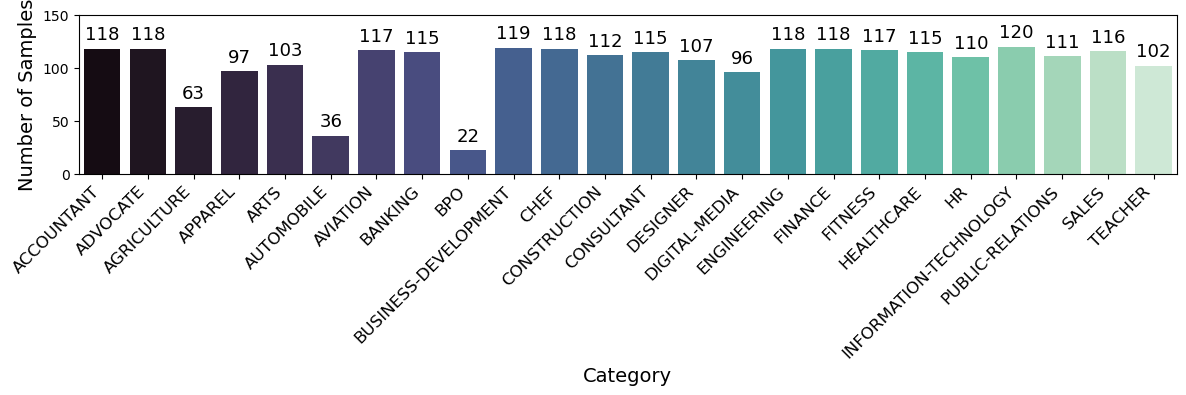

In [10]:
plt.figure(figsize=(12,4))

# Creating a plot with Seaborn.
ax = sns.countplot(x='class', hue='class', data=data, palette="mako", legend=False)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Number of Samples", fontsize= 14)
plt.ylim(0, max(data['class'].value_counts()) + 30)  # Setting the y-axis limit. 

# Setting the x-ticks labels to match the categories in the dataset.
plt.xticks(fontsize=12, rotation=45, ha='right')
# Rotate the x-labels by 45 degrees for better readability

# Annotating the bars with the count of documents in each category.
for p in ax.patches:
    ax.annotate(int(p.get_height()),  # height of the bars - i.e. number of docs
                (p.get_x() + 0.4, p.get_height()),  # Position for the annotation.
                ha='center', va = 'center', 
                xytext = (0, 10),  # Distance from the top of the bar.
                textcoords = 'offset points',
                fontsize=13)

# Adjust layout (make sure everything is visible in the saved img)
plt.tight_layout()

# Save the figure in the 'figs' folder
plt.savefig(f'{folder_name}/Number_of_samples_per_category.png')
plt.show()

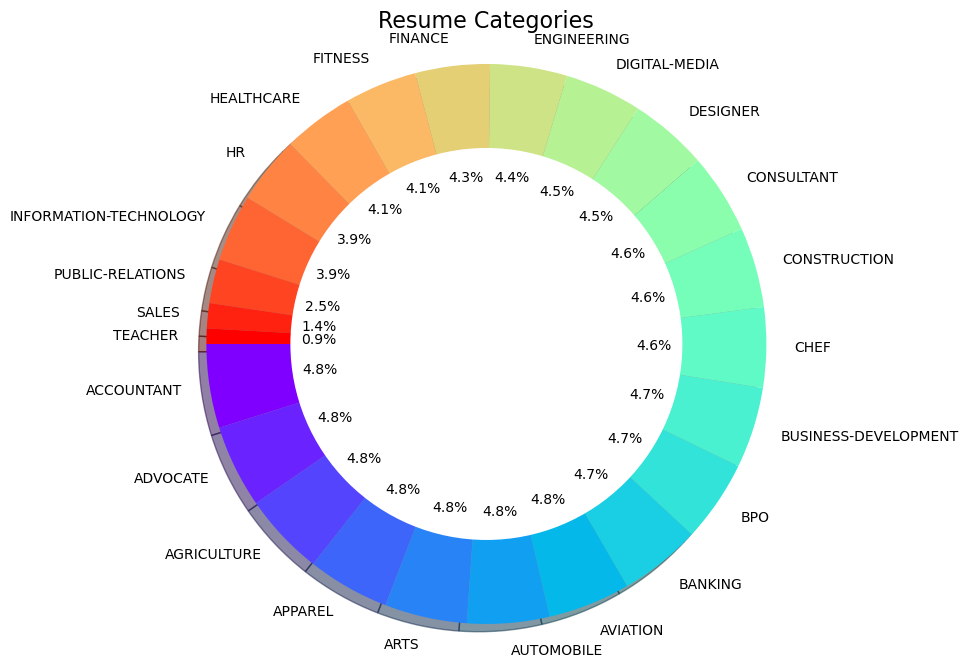

In [11]:
# Create a color palette for other vizu
counts=data['class'].value_counts()
labels=data['class'].unique()

colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))

# Create pie plot
plt.figure(figsize=(12, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', shadow=True, colors=colors, startangle=180)

# Add a circle at the center to simulate depth perception
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle) #empty center

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')
plt.title("Resume Categories", fontsize=16)

# Save the figure in the 'figs' folder
plt.savefig(f'{folder_name}/Resume_Categories.png')
plt.show()

The pie chart illustrates the class distribution within the dataset, seems to be balanced overall.

# 4. Prepare data

In [69]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Apply the preprocessing function to clean the text
data['cleaned_resume'] = data['resume_str'].apply(prepare_data.preprocess_text)

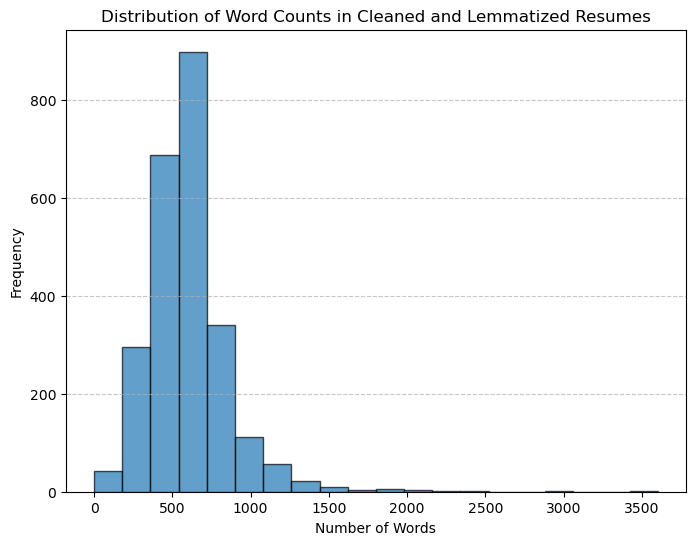

In [65]:
# vizu

# Calculate the number of words in each cleaned resume and add it as a new column
data['word_count'] = data['cleaned_resume'].apply(lambda x: len(x.split()))

# Create a histogram to visualize the distribution of word counts
plt.figure(figsize=(8, 6))
plt.hist(data['word_count'], bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Cleaned and Lemmatized Resumes')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save the figure in the 'figs' folder
plt.savefig(f'{folder_name}/Word_counts.png')
plt.show()

# spacy

In [70]:
# #save the dataframe
# path_df = 'data/clean_data.csv'
# data.to_csv(path_df, index=False, header=True)

In [71]:
words = nltk.word_tokenize(combined_text)
# words

In [78]:
len(words)

1511245

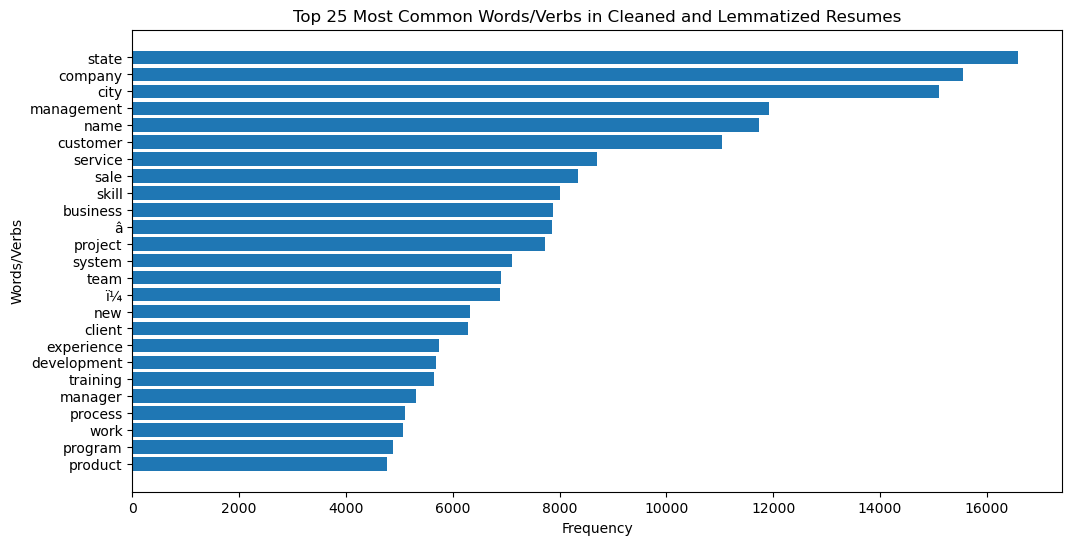

In [80]:
# Count the freq of words

# Combine all the cleaned text and divide it into a list of words
combined_text = ' '.join(data['cleaned_resume'])
words = nltk.word_tokenize(combined_text)

# Calculate the frequency of each word
word_freq = Counter(words)
top_25_words = word_freq.most_common(25) #most frequent

# Get the words and their frequencies
top_words, top_word_counts = zip(*top_25_words)

# Create a bar chart to visualize the top 25 words/verbs
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_words)), top_word_counts, align='center')
plt.yticks(range(len(top_words)), top_words)
plt.xlabel('Frequency')
plt.ylabel('Words/Verbs')
plt.title('Top 25 Most Common Words/Verbs in Cleaned and Lemmatized Resumes')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most common words at the top
plt.show()

Some words seem to be non necessary for resume classification (e.g. company, city)

In [1]:
import json
# Define a list of words to remove from the entire dataset and remove custom stopwords
custom_stopwords = ['company', 'city', 'state', 'name', 'skill', 'experience', 'â', 'ï¼']

# Save it in a JSON file
with open('custom_stopwords.json', 'w') as file:
    json.dump(custom_stopwords, file)

In [3]:
import json

# Loading the array from the JSON file
with open('custom_stopwords.json', 'r') as file:
    custom_stopwords = json.load(file)

print(custom_stopwords)


['company', 'city', 'state', 'name', 'skill', 'experience', 'â', 'ï¼']


In [108]:
# data['cleaned_resume'] = data['cleaned_resume'].apply(prepare_data.remove_custom_stopwords)
data['cleaned_resume'] = data['cleaned_resume'].apply(lambda x: prepare_data.remove_custom_stopwords(x, custom_stopwords))

# Save the cleaned DataFrame to a new CSV file
data.to_csv('data/cleaned_data_v2.csv', index=False)

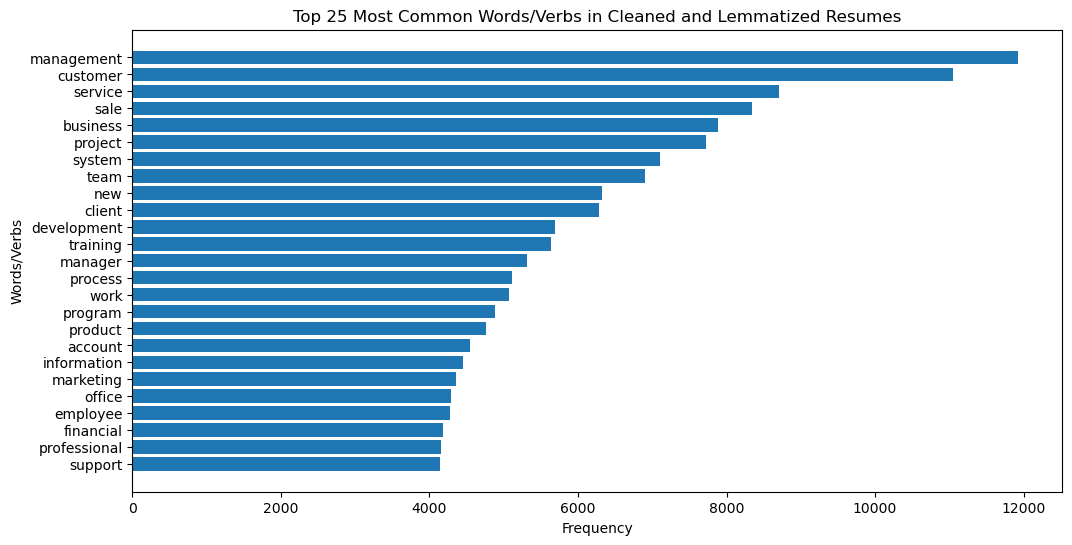

In [109]:
# Count the freq of words

# Combine all the cleaned text and divide it into a list of words
combined_text = ' '.join(data['cleaned_resume'])
words = nltk.word_tokenize(combined_text)

# Calculate the frequency of each word
word_freq = Counter(words)
top_25_words = word_freq.most_common(25) #most frequent

# Get the words and their frequencies
top_words, top_word_counts = zip(*top_25_words)

# Create a bar chart to visualize the top 25 words/verbs
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_words)), top_word_counts, align='center')
plt.yticks(range(len(top_words)), top_words)
plt.xlabel('Frequency')
plt.ylabel('Words/Verbs')
plt.title('Top 25 Most Common Words/Verbs in Cleaned and Lemmatized Resumes')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most common words at the top

# Save the figure in the 'figs' folder
plt.savefig(f'{folder_name}/Most_common_words_after.png')
plt.show()

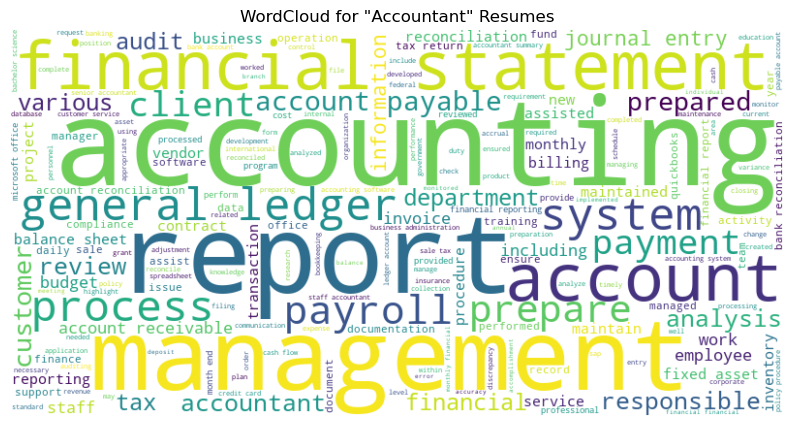

In [18]:
# wordcloud in a category

# Select "accountant" category
accountant_df = data[data['class'] == 'ACCOUNTANT']
combined_text = ' '.join(accountant_df['cleaned_resume'])

# Create a WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Display the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud for "Accountant" Resumes')
plt.axis('off')

# Save the figure in the 'figs' folder
plt.savefig(f'{folder_name}/WordCloud_Accountant.png')
plt.show()

In [83]:
# Prepare data - train-test split
from sklearn.model_selection import train_test_split


# Stratified split (80-20 Split) - Train/test
train_data, test_data = train_test_split(data.loc[:,['class', 'cleaned_resume']], test_size=0.2, stratify=data['class'], random_state=42)

# Stratified split (90-10 Split) - Train/val
train_data, val_data = train_test_split(train_data, test_size=0.1, stratify=train_data['class'], random_state=42)

# Save the Datasets to CSV Files
path_dir = 'data/'
train_data.to_csv(path_dir +'train_data.csv', index=False)
test_data.to_csv(path_dir+ 'test_data.csv', index=False)
val_data.to_csv(path_dir+'val_data.csv', index=False)

# Print a message to indicate successful completion.
print(f'Training set shape: {train_data.shape}')
print(f'Val set shape: {val_data.shape}')
print(f'Test set shape: {test_data.shape}')
print("Datasets successfully split and saved as CSV files.")


Training set shape: (1787, 2)
Val set shape: (199, 2)
Test set shape: (497, 2)
Datasets successfully split and saved as CSV files.


# 5. Upload the dataset to S3 bucket

In [97]:
from IPython.display import display, HTML
import botocore
import boto3

In [100]:
# Configure a custom user agent string for Boto3 requests
user_agent_string = 'mon-agent-utilisateur-personnalisé/resumes/v0.1'
config = botocore.config.Config(user_agent_extra=user_agent_string)

# # Create an S3 client with the custom configuration
s3_client = boto3.client(service_name='s3', config=config)

# Create the custom S3 bucket
bucket_name = "docu-classification" # Custom bucket
region_name = sess.boto_region_name # Specify the region
print('S3 Bucket: {}'.format(bucket_name))
print('Region: {}'.format(region_name))

try:
    s3_client.create_bucket(Bucket=bucket_name,
                            CreateBucketConfiguration={'LocationConstraint': region_name})
    print(f"Bucket {bucket_name} successfully created.")
except s3_client.exceptions.BucketAlreadyExists as e:
    print(f"The bucket {bucket_name} already exists.")
except s3_client.exceptions.BucketAlreadyOwnedByYou as e:
    print(f"The bucket {bucket_name} is already owned by the user.")
except Exception as e:
    print(f"Error occurred while creating the bucket: {e}")
    
    
# Create the folder data inside the bucket
folder_name = "data/" 
try:
    # Uploading an empty file to create a folder-like prefix
    s3_client.put_object(Bucket=bucket_name, Key=folder_name)
    print(f"Folder '{folder_name}' created in bucket '{bucket_name}'.")
except Exception as e:
    print(f"Error occurred while creating the folder: {e}")

# Display a hyperlink to the Amazon S3 bucket for easy access.
display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}#">Amazon S3 bucket</a></b>'.format(region)))

S3 Bucket: docu-classification
Region: eu-north-1
Bucket docu-classification successfully created.
Folder 'data/' created in bucket 'docu-classification'.


In [119]:
file_names = ["data/" + filename + ".csv" for filename in ["cleaned_data_v2", "train_data", "val_data", "test_data"]]
s3_key = ["data/" + new_filename + ".csv" for new_filename in ["data", "train_data", "val_data", "test_data"]]

for i in range(len(file_names)) :
    # print(file_names[i]
    try:
        response = s3_client.upload_file(file_names[i], bucket_name, s3_key[i])
        print(f"File {file_names[i]} uploaded to {bucket_name}/{s3_key[i]}.")
    except Exception as e:
        print(f"Error occurred while uploading file: {e}")

File data/cleaned_data_v2.csv uploaded to docu-classification/data/data.csv.
File data/train_data.csv uploaded to docu-classification/data/train_data.csv.
File data/val_data.csv uploaded to docu-classification/data/val_data.csv.
File data/test_data.csv uploaded to docu-classification/data/test_data.csv.
